# Theory/ Formulae for Computation

There are many methods that can easily be implemented in python with only standard math library, or numpy such as, but not limited to :
- Haversine's Method[<sup>1</sup>](#Links-and-References)
- Vicenty's Method[<sup>2</sup>](#Links-and-References)
- Geodesic Calculation[<sup>3</sup>](#Links-and-References)

For the sake of simplicity and efficiency, we chose to use a fully implemented and trusted Python library, Geopy[<sup>4</sup>](#Links-and-References), created for this precise purpose. They implementboth Vicenty's method and Geodesic Calculation, which has, out of the three methods, the best accuracy.

# Code

In [42]:
# Import libraries

import geopy.distance
import pandas as pd
from ipywidgets import interactive
import ipywidgets as widgets

In [43]:
# File name/path
file = 'data.csv'

In [44]:
# Function calculating distance between the two points uisng Pyhton Geopy library.
# Input : A Correctly formatted Row of Data
# Output : Distance "as-the-crow-flies" in meters

def distance(row):
    try:        
        coord_A = (float(row['PointA_latitude']), float(row['PointA_longitude']))
        coord_B = (float(row['PointB_latitude']), float(row['PointB_longitude']))
        
        return geopy.distance.distance(coord_A, coord_B).m
            
    except ValueError :
        return 

In [45]:
# Open and parse the CSV file
data = pd.read_csv(file)

# Remove all lines with missing data
data.dropna(inplace=True)

#Create a new column 
data['Distance_m'] = data.apply(lambda row : distance(row), axis = 1)

# Change Time data to Pandas' timestamp type to enable easier graphical representation
data.rename(index=str, columns={"YYYY/MM/DD Time": "YYYY-MM-DD Time"}, inplace=True)
data['YYYY-MM-DD Time'] = pd.to_datetime(data['YYYY-MM-DD Time'], format = "%Y/%m/%d %H:%M", errors='coerce')

# Remove any errors that may have appeared in the processes
data.dropna(inplace=True)

In [46]:
# Basic information on our data
data['Distance_m'].describe()

count       230.000000
mean       1186.968314
std        7924.561136
min           0.000000
25%          13.472705
50%          43.910663
75%         196.369759
max      101428.742650
Name: Distance_m, dtype: float64

At first glance, these results seem really bad. No geolocalization is possible with an average of 1186 meters precision.
But this is to be taken with a grain of salt because of the few exceptions over the 10km threshold. Looking at the 3rd Quantile we can see that most of the readings are still in a reasonable range ~200m.

# Plots and Data Analysis

## Temporal Effect

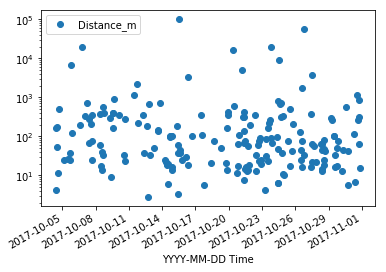

In [47]:
# Examining Error distribution in function of the date
data.plot(x='YYYY-MM-DD Time', y='Distance_m', style='o', logy=True)

We can see that the GPS system efficiency doesn't vary with time. We will use that fact later. 

## Visualisation of Distance Repartition

### Mean and Quantiles

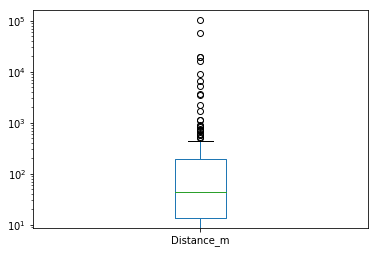

In [48]:
# BoxPlot in logarithmic scale of distance obtained
data.plot(y='Distance_m', kind='box', style='o', logy=True)

With this repartition, we see that about 50% of the values are under 50 meters and 75% under 200 meters.
A 50 meters precision isn't that great, but it can be exploited and refined in order to geolocalize a driver with sufficient precision (Bigger roads tend to be spaced more than 50m from each other).

### Distribution

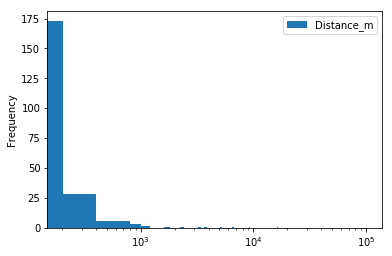

In [49]:
#Histogram of the Distance with logarithmic scale for the x-axis
data.plot(y='Distance_m', kind='hist', style='o', bins=500, logx=True)

Here we can see that effeectively very few readings have tremendous errors. But the level of precision isn't satisfying either. This could be due to the lack of data (only 230 readings were exploitable)

## Excluding Exceptional Values

In [50]:
def plot(q):
    # We cut the bigger values from our data set and observe only the quantile we desire, for better graphical representation
    cut_value = data['Distance_m'].quantile(q)
    datasub = data[data['Distance_m'] < cut_value]

    datasub.plot(y='Distance_m', kind='hist', style='o', bins=50)

In [51]:
# Interactive Histogram
quantile = interactive(plot, q=widgets.FloatSlider(min=.25,max=1,step=.05,value=.95))
display(quantile)

interactive(children=(FloatSlider(value=0.95, description='q', max=1.0, min=0.25, step=0.05), Output()), _dom_…

# Conclusion

 From what we have learnt from the data, the GPS System used by the prefectures have some major flaws, notably in their precision, which make them hard to use in everyday life.
       
 However, its performances are constant with time, meaning that we could use several measures in order to do only one localization with a better precision. This solution could be profitable if the cost of changing the system is too high to be invested, be it right now or later.
       
 As about 50% of the measures have a precision of at least 50 meters, so with 15 measures of the same point, we have 95% chance to have 5 measures at less than 50 meters of the target. By epurating the obviously wrong measures and by calculating the average position of our point, we can achieve a good enough precision for driving localization or for rescuing stranded users.

 By checking the FAA (Federal Administration of Aviation) governmental website[<sup>5</sup>](#Links-and-References) we managed tofind some comparative data.
In the figure below we can see that our system performance's are indeed way inferior to what is actually readily available by civillians, let alone governments (eg. WAAS System, GDGPS, CORS...).

Horizontal Error for FAA GPS System | Vertical Error for FAA GPS System
- | - 
![alt](figFAA.png) | ![alt](figFAA1.png)

The cost of changing the GPS System of every prefecture may be high but the gain in precision and efficiency may be quite worth it depending on the desired applications.


# Links and References

1. Wikipedia Article on Haversine Calculation Method :https://en.wikipedia.org/wiki/Haversine_formula
2. Wikipedia Article on Vicenty Calculation Method : https://en.wikipedia.org/wiki/Vincenty%27s_formulae
3. Wikipedia Article on Geodesic Calculation Method : https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid
4. Geopy's API Reference Website : https://geopy.readthedocs.io/en/stable/
5. FAA Governmental Website : http://www.nstb.tc.faa.gov/reports/PAN96_0117.pdf#page=22